#### Enable Colab to access Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fellowshipai-data/new_all_data_3class/'



Mounted at /content/gdrive


In [0]:
base_dir

'/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/'

# Creating a dataset from Google Images

*Following the example by Jeremy Howard in fastai course v3 tutorial 2. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In [0]:
from fastai import *
from fastai.vision import *
import numpy as np

## Get a list of URLs

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [0]:
folder = 'baconburnt'
file = 'baconburnt.txt'

You will need to run this cell once per each category.

In [0]:
path = Path(base_dir)
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)


In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/raw'),
 PosixPath('/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/cooked'),
 PosixPath('/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/burnt'),
 PosixPath('/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/doneness_3class_jeff.ipynb'),
 PosixPath('/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/models')]

### Download images 
Download images listed in text file urls to path dest, at most `max_pics`

`download_images(urls:StrList, dest:PathOrStr, max_pics:int=1000, max_workers:int=8, timeout=4)`

#### Notes on Image Scraping
"Garbage in and garbage out" is completely true. From empirical results, the cleaner the images, (less background noise, plain white background) the better the training, as reflected by the loss vs. learning rate curve. 

####Download images to server (Google drive) 

In [0]:
download_images(path/file, dest, max_pics=200)
# doc(download_images)

### Remove any invalid images that can't be opened

`verify_images[source][test]
verify_images(path:PathOrStr, delete:bool=True, max_workers:int=4, max_size:int=None, recurse:bool=False, dest:PathOrStr='.', n_channels:int=3, interp=2, ext:str=None, img_format:str=None, resume:bool=None, **kwargs)`

Check if the images in path aren't broken, maybe resize them and copy it in dest.

It will try if every image in this folder can be opened and has `n_channels`. If `n_channels` is 3 – it'll try to convert image to RGB. If `delete=True`, it'll be removed it this fails. If `resume` – it will skip already existent images in dest. If `max_size` is specified, image is resized to the same ratio so that both sizes are less than max_size, using interp. Result is stored in dest, `ext` forces an extension type, `img_format` and kwargs are passed to PIL.Image.save. Use `max_workers` CPUs.

In [0]:
classes = ['raw','cooked','burnt']  # raw 1419, cooked 1302 , burnt 339
for c in classes:
    print(c)
    verify_images(path/c, delete=True, resume=True, max_size=1000)


### Dupe Image Remover with dhash algo

In [0]:
#!/usr/bin/env python
# coding: utf-8

# In[6]:


import os
!pip install dhash
import dhash
import collections
from PIL import Image

class dhasher:
    
    def __init__(self, directories):
        self.directories = directories
        file_dirs, unq_files = self.filer()
        dhash_mtrx = self.difhashmtrx(file_dirs,unq_files)
        self.detectduplicates(dhash_mtrx,file_dirs)
        
    def filer(self):
        file_dirs = [[] for x in range(len(self.directories))]
        unq_files = [[] for x in range(len(self.directories))]
        counter = 0
        total_files = 0
        for d in self.directories:
            os.chdir(d)
            path = os.getcwd()
            for filename in os.listdir(path):
                filepath = os.path.join(path, filename)
                file_dirs[counter].append(filepath)
                unq_files[counter].append(filename[filename.find('.')+1:len(filename)-4]) 
            print(len(unq_files[counter]),"total images in",path)
            total_files += len(unq_files[counter])
            counter += 1
        print('\n',total_files,"total images in all classes.")
        return file_dirs, unq_files
    
    def difhashmtrx(self, file_dirs,unq_files):
        print("\nForming Dhash (Size = 8) Matrix...")
        dif_hash_mtrx = [[] for x in range(len(self.directories))]
        c1 = 0
        unhashed = []
        for clas in file_dirs:
            for image_path in clas:
                try:
                    image = Image.open(image_path).convert("RGBA") # All palette images with transparency expressed in bytes should converted to RGBA images 
                    row, col = dhash.dhash_row_col(image)
                    image_hash = dhash.format_hex(row, col)
                    dif_hash_mtrx[c1].append(image_hash)
                except:
                    unhashed.append(image_path)
                    print(image_path," - file type is unhashable.")
            c1 += 1
        print(len(unhashed)," images ignored.")
        return dif_hash_mtrx
            
    def detectduplicates(self, dif_hash_mtrx,file_dirs):
        # Find common elements within sublists of the dhash matrix
        duplicate_indx_mtrx = []
        unq_elems_mtrx = []
        across_file_duplicates = []
        c1 = 0
        print("\nDhashing...")
        for z in dif_hash_mtrx:
            duplicate_indx = [i for i in range(len(z)) if not i == z.index(z[i])]
            unq_elems = [z[i] for i in range(len(z)) if i == z.index(z[i])]
            unq_elems_mtrx.append(unq_elems)
            duplicate_indx_mtrx.append(duplicate_indx)
            print(len(z)-len(unq_elems),"duplicate images within",self.directories[c1],"found.")
            c1 += 1

        # Find common elements across sublists of the dhash matrix - this should be 0 (or very close to it)
        unq_elems_mtrx_list = [item for sublist in unq_elems_mtrx for item in sublist]
        if len(unq_elems_mtrx_list) - len(set(unq_elems_mtrx_list)) == 0:
            print("No duplicate images across classes.")
        else: 
            print(len(unq_elems_mtrx_list) - len(set(unq_elems_mtrx_list)),"duplicate images across classes found.")
            unq_a = [item for item, count in collections.Counter(unq_elems_mtrx_list).items() if count > 1]
            print("\nDuplicates in 2 or more classes:")
            for a in unq_a:
                for i in range(len(file_dirs)):
                    try:
                        file_path = file_dirs[i][dif_hash_mtrx[i].index(a)]
                        across_file_duplicates.append(file_path)
                        print('\n',file_path)
                    except:
                        continue
                        #print("Image not in",self.directories[i])
        return across_file_duplicates

raw_dir = root_dir + 'fellowshipai-data/new_all_data_3class/raw/'
med_dir = root_dir + 'fellowshipai-data/new_all_data_3class/cooked/'
well_dir = root_dir + 'fellowshipai-data/new_all_data_3class/burnt/'
dir_list = [raw_dir,med_dir,well_dir]

dhasher(dir_list)    

  Created wheel for dhash: filename=dhash-1.3-cp36-none-any.whl size=7274 sha256=0f6ec32642304097e44d278c40f8e28553e9d7d64682c5d738a0b0f4dbe9eba3
  Stored in directory: /root/.cache/pip/wheels/a4/cb/88/d7cf61a1ac52042d59cc0c7a130c04b1541dfd439570c6ea41
Successfully built dhash
1424 total images in /content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/raw
1303 total images in /content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/cooked
340 total images in /content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/burnt

 3067 total images in all classes.

Forming Dhash (Size = 8) Matrix...
/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/raw/Copy of 00000166.jpg  - file type is unhashable.
/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/raw/Copy of 00000175.jpg  - file type is unhashable.
/content/gdrive/My Drive/fellowshipai-data/new_all_data_3class/raw/Copy of 00000479 (1).jpg  - file type is unhashable.


### Create Baseline Dataset with .20 Validation Split

In [28]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

data.classes

['burnt', 'cooked', 'raw']

In [29]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['burnt', 'cooked', 'raw'], 3, 2431, 607)

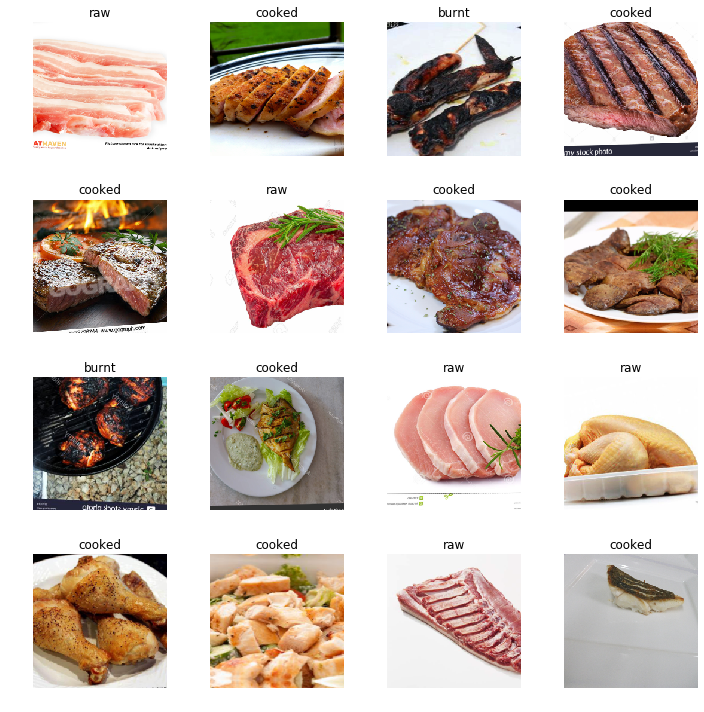

In [0]:
data.show_batch(rows=4, figsize=(10,10))

### Transfer learning
Transfer learning is a technique where you use a model trained on a very large dataset (usually ImageNet in computer vision) and then adapt it to your own dataset. The idea is that it has learned to recognize many features on all of this data, and that you will benefit from this knowledge, especially if your dataset is small, compared to starting from a randomly initialized model. It has been proved in this article on a wide range of tasks that transfer learning nearly always give better results.

In practice, you need to change the last part of your model to be adapted to your own number of classes. Most convolutional models end with a few linear layers (a part we will call the head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (called the body or the backbone of the model) with their weights pretrained on ImageNet but will define a new head initialized randomly.

Then we will train the model we obtain in two phases: first we freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data), then we unfreeze the layers of the backbone (gradually if necessary) and fine-tune the whole model (possibly using differential learning rates).

The `cnn_learner` factory method helps you to **automatically get a pretrained model from a given architecture with a custom head** that is suitable for your data.


## Train model

Build convnet style learner.

This method creates a Learner object from the data object and model inferred from it with the backbone given in `base_arch`. Specifically, it will cut the model defined by arch (randomly initialized if pretrained is False) at the last convolutional layer by default (or as defined in cut, see below) and add:

an AdaptiveConcatPool2d layer,
a Flatten layer,
blocks of [nn.BatchNorm1d, nn.Dropout, nn.Linear, nn.ReLU] layers.

`cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[Module]=None, split_on:Union[Callable, Collection[ModuleList], NoneType]=None, bn_final:bool=False, init='kaiming_normal_', concat_pool:bool=True, **kwargs:Any) → Learner`




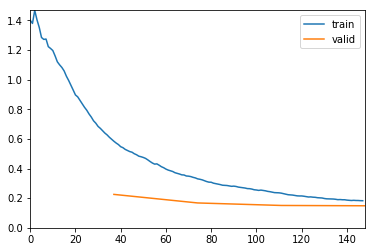

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


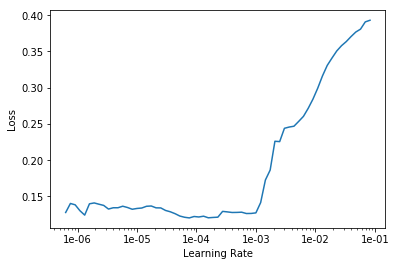

In [30]:
# init cnn rn34
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,
                                                    error_rate,
                                                    Precision(average='macro'),
                                                    Recall(average='macro')], 
                    callback_fns=ShowGraph)

# fit the head (output layer)
learn.fit_one_cycle(4) 
learn.save('rn34-stage-1')

# now fit the pretrained early layers too
learn.unfreeze()
learn.lr_find()

learn.recorder.plot(suggestion=False)  # .035775 3 epoch

### fit_one_cycle
`fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)`

#### Fit a model following the 1cycle policy.

Use cycle length `cyc_len`, a per cycle maximal learning rate `max_lr`, momentum `moms`, division factor `div_factor`, weight decay `wd`, and optional callbacks `callbacks`. Uses the `OneCycleScheduler` callback. Please refer to What is 1-cycle for a conceptual background of 1-cycle training policy and more technical details on what do the method's arguments do.



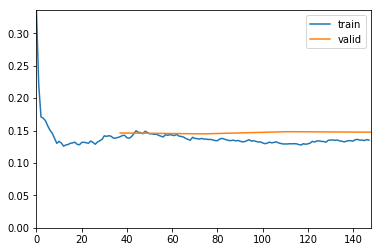

In [31]:
learn.load('rn34-stage-1')

# train on entire unfrozen network (early layers are pretrained)
learn.fit_one_cycle(4, max_lr=slice(1e-048,1e-042))
learn.save('rn34-stage-2') # .03125 4 epochs

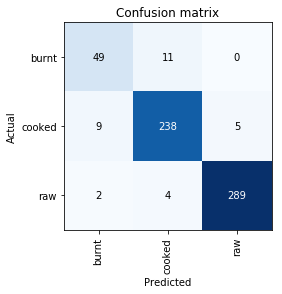

In [32]:
learn.load('rn34-stage-2')

interp34 = ClassificationInterpretation.from_learner(learn)

interp34.plot_confusion_matrix()

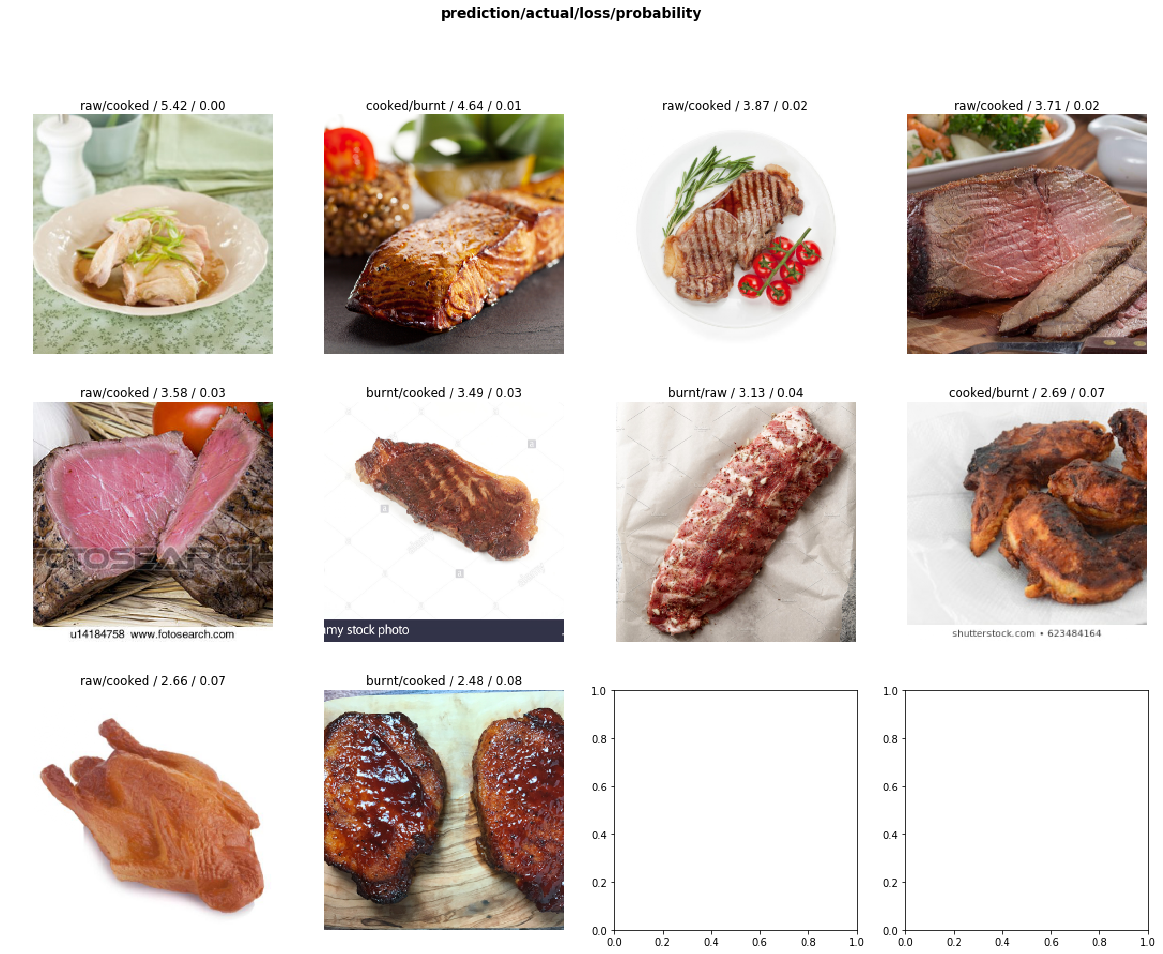

In [33]:
interp34.plot_top_losses(10,figsize=(20,15))

# model is learning whole chickens as raw due to lack of cooked whole chicken examples 

### Data Augmentation

Data augmentation is perhaps the *most important* regularization technique when training a model for Computer Vision: instead of feeding the model with the same pictures every time, we do *small random transformations* (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image (to the human eye) but *do change its pixel values*. **Models trained with data augmentation will then generalize better**.

To get a set of transforms with default values that work pretty well in a wide range of tasks, it's often easiest to use `get_transforms`. Depending on the nature of the images in your data, you may want to adjust a few arguments, the most important being:

`do_flip`: if True the image is randomly flipped (default behavior)
`flip_vert`: limit the flips to horizontal flips (when False) or to horizontal and vertical flips as well as 90-degrees rotations (when True)
get_transforms returns a tuple of two lists of transforms: one for the training set and one for the validation set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to resizing the pictures). This can be passed directly to define a `DataBunch` object (see below) which is then associated with a model to begin training.

Note that the defaults for `get_transforms` are generally pretty good for regular photos - although here we'll add a bit of extra rotation so it's easier to see the differences.

We first define a function to return a new image, since transformation functions modify their inputs. We also define a little helper function `plots_f` to let us output a grid of transformed images based on a function - the details of this function aren't important here.

If we want to have a look at what these transforms actually do, we need to use the `apply_tfms` function. It will be in charge of picking the values of the random parameters and doing the transformations to the Image object. This function has multiple arguments you can customize (see its documentation for details); here we will highlight the most useful. The first one we'll need to set, especially if our images are of different shapes, is the target size. It will ensure that all the images are cropped or padded to the same size so we can then collate them into batches.

Note that the target size can be a rectangle if you specify a tuple of int.

The second argument that can be customized is how we treat missing pixels: when applying transforms (like a rotation), some of the pixels inside the square won't have values from the image. We can set missing pixels to one of the following:

black (`padding_mode='zeros'`)
the value of the pixel at the nearest border (`padding_mode='border'`)
the value of the pixel symmetric to the nearest border (`padding_mode='reflection'`)
`padding_mode='reflection'` is the default. Here is what `padding_mode='zeros'` looks like:

The third argument that might be useful to change is `resize_method`. Images are often rectangles of different ratios, so to get them to the target size, we may need to crop, squish, or pad them to get the ratio right.

By default, the library resizes the image while keeping its original ratio so that the smaller size corresponds to the given size, then takes a crop (`ResizeMethod.CROP`). You can choose to resize the image while keeping its original ratio so that the bigger size corresponds to the given size, then take a pad (`ResizeMethod.PAD`). Another way is to just squish the image to the given size (`ResizeMethod.SQUISH`).

### Data augmentation details
If you want to quickly get a set of random transforms that have worked well in a wide range of tasks, you should use the get_transforms function. The most important parameters to adjust are `do_flip` and `flip_vert`, depending on the type of images you have.

**`get_transforms`**

`get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]`

Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

- `do_flip`: if `True`, a random flip is applied with probability 0.5
- `flip_vert`: requires `do_flip=True`. If `True`, the image can be flipped vertically or rotated by 90 degrees, otherwise only an horizontal flip is applied

- `max_rotate`: if not `None`, a random rotation between `-max_rotate` and `max_rotate` degrees is applied with probability `p_affine`
- `max_zoom`: if not 1. or less, a random zoom betweem 1. and `max_zoom` is applied with probability `p_affine`
- `max_lighting`: if not `None`, a random lightning and contrast change controlled by `max_lighting` is applied with probability `p_lighting`
- `max_warp`: if not `None`, a random symmetric warp of magnitude between `-max_warp` and `maw_warp` is applied with probability `p_affine`
- `p_affine`: the probability that each affine transform and symmetric warp is applied
- `p_lighting`: the probability that each lighting transform is applied
- `xtra_tfms`: a list of additional transforms you would like to be applied

This function returns a tuple of two lists of transforms, one for the training set and the other for the validation set (which is limited to a center crop by default).

Another useful function that gives basic transforms is `zoom_crop`:

**`zoom_crop`**

`zoom_crop(scale:float, do_rand:bool=False, p:float=1.0)`


Randomly zoom and/or crop.

- `scale`: Decimal or range of decimals to zoom the image
- `do_rand`: If true, transform is randomized, otherwise it's a zoom of scale and a center crop
- `p`: Probability to apply the zoom

`scale` should be a given float if `do_rand` is `False`, otherwise it can be a range of floats (and the zoom will have a random value in between). 

Again, here is a sense of what this can give us:


### `rand_resize_crop`
`rand_resize_crop(size:int, max_scale:float=2.0, ratios:Point=(0.75, 1.33))
`

Randomly resize and crop the image to a ratio in ratios after a zoom of `max_scale`.

- `size`: Final size of the image
- `max_scale`: Zooms the image to a random scale up to this
- `ratios`: Range of ratios in which a new one will be randomly picked

**This transform is an implementation of the main approach used for nearly all winning Imagenet entries since 2013**, based on Andrew Howard's Some Improvements on Deep Convolutional Neural Network Based Image Classification. 

It determines a new width and height of the image after the random scale and squish to the new ratio are applied. Those are switched with probability 0.5. Then we return the part of the image with the width and height computed, centered in `row_pct`, `col_pct` if width and height are both less than the corresponding size of the image. Otherwise we try again with new random parameters.

### Randomness
The functions that define each transform, such as rotateor `flip_lr` are deterministic. The fastai library will then randomize them in two different ways:

- each transform can be defined with an argument named `p` representing the probability for it to be applied

- each argument that is type-annotated with a random function (like `uniform` or `rand_bool`) can be replaced by a tuple of arguments accepted by this function, and on each call of the transform, the argument that is passed inside the function will be picked randomly using that random function.

If we look at the function `rotate` for instance, we see it has an argument `degrees` that is type-annotated as uniform.

**First level of randomness**: We can define a transform using `rotate` with degrees fixed to a value, but by passing an argument `p`. The rotation will then be executed with a probability of `p` but always with the same value of `degrees`.


### All combined: 
We can define a transform using `rotate` with `degrees` defined as a range, and an argument `p`. The rotation will then be executed with a probability `p` and with a random value picked uniformly between the two floats we put in `degrees`.

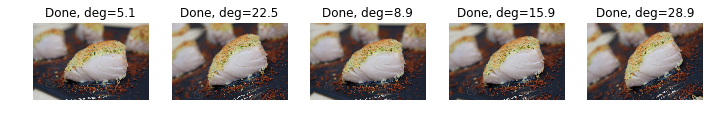

In [0]:
tfm = [rotate(degrees=(-30,30), p=0.75)]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    img = get_ex('cooked','00000157.jpg').apply_tfms(tfm)
    title = f"Done, deg={tfm[0].resolved['degrees']:.1f}" if tfm[0].do_run else f'Not done'
    img.show(ax=ax, title=title)

### Convenience functions
These functions simplify creating random versions of crop_pad and zoom.

**`rand_crop`**

`rand_crop(*args, padding_mode='reflection', p:float=1.0)`

Randomized version of `crop_pad`.

The args are for internal purposes and shouldn't be touched.


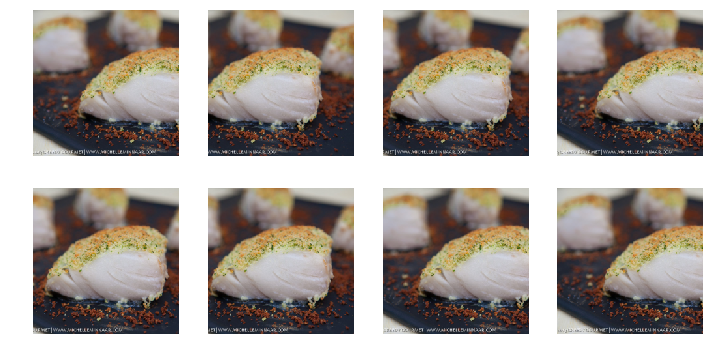

In [0]:
tfm = rand_crop()
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex('cooked','00000157.jpg').apply_tfms(tfm, size=224)
    img.show(ax=ax)

### `rand_pad`

`rand_pad(padding:int, size:int, mode:str='reflection')`

Fixed `mode` `padding` and random crop of `size`

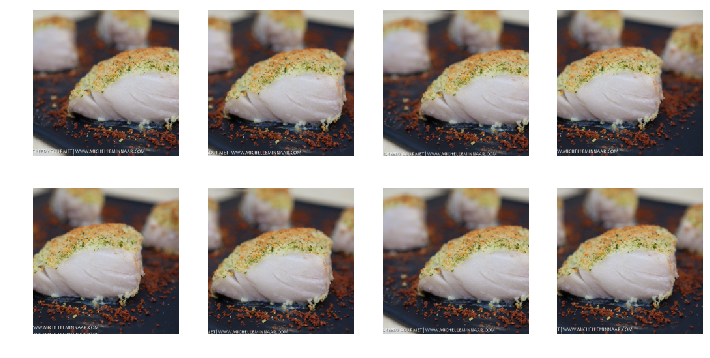

In [0]:
tfm = rand_pad(4, 224)
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex('cooked','00000157.jpg').apply_tfms(tfm, size=224)
    img.show(ax=ax)

### `rand_zoom`

`rand_zoom(scale:uniform=1.0, p:float=1.0)`

*Randomized* version of `zoom`.

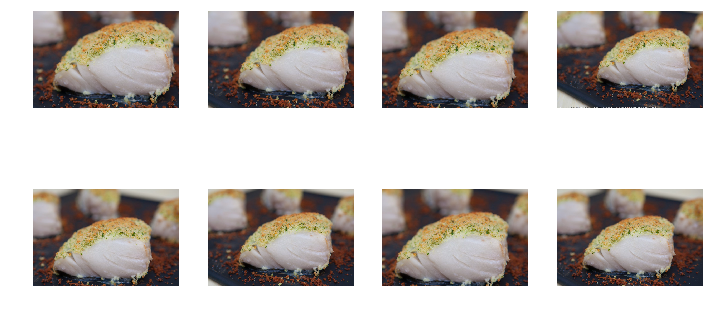

In [0]:
tfm = rand_zoom(scale=(1.,1.5))
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex('cooked','00000157.jpg').apply_tfms(tfm)
    img.show(ax=ax)

### Quickly get your data ready for training
To get you started as easily as possible, fastai provides two helper functions to create a `DataBunch` object that you can directly use for training a classifier. 

Here the datasets will be automatically created in the structure of Imagenet-style folders. The parameters specified:

the transforms to apply to the images in `ds_tfms` (here with `do_flip=True` because we don't mind flipping food images, but might not want to flip numbers), the target size of our pictures (here 24).

As with all `DataBunch` usage, a `train_dl` and a `valid_dl` are created that are of the type `PyTorch DataLoader`.

If you want to have a look at a few images inside a batch, you can use `DataBunch.show_batch`. The `rows` argument is the number of rows and columns to display.



### Augmentation Transforms 
If you want to quickly get a set of random transforms that have worked well in a wide range of tasks, you should use the `get_transforms` function. The most important parameters to adjust are `do_flip` and `flip_vert`, depending on the type of images you have.

### get_transforms
`get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]`


Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

- `do_flip`: if `True`, a random flip is applied with probability 0.5
- `flip_vert`: requires `do_flip=True`. If `True`, the image can be flipped vertically or rotated by 90 degrees, otherwise only an horizontal flip is applied
- `max_rotate`: if not `None`, a random rotation between -`max_rotate` and `max_rotate` degrees is applied with probability `p_affine`
- `max_zoom`: if not 1. or less, a random zoom betweem 1. and `max_zoom` is applied with probability `p_affine`
- `max_lighting`: if not `None`, a random lightning and contrast change controlled by `max_lighting` is applied with probability `p_lighting`
- `max_warp`: if not `None`, a random symmetric warp of magnitude between `-max_warp` and `max_warp` is applied with probability `p_affine`
- `p_affine`: the probability that each affine transform and symmetric warp is applied
- `p_lighting`: the probability that each lighting transform is applied
- `xtra_tfms`: a list of additional transforms you would like to be applied
This function returns a tuple of two lists of transforms, one for the training set and the other for the validation set (which is limited to a center crop by default).

In [0]:
def get_ex(folder_name,img_name): 
    f_path = folder_name+'/'+img_name
    return open_image(path/f_path)

# def plot_tfms(folder_name,img_name,tfms,xtra_tfms,n_trans=5):
def plot_tfms(folder_name,img_name,tfms,n_trans=5,**kwargs):
    fig,axs = plt.subplots(1,n_trans,figsize=(12,12))
    for ax in axs:
        get_ex(folder_name,img_name).apply_tfms(tfms[0],**kwargs).show(ax=ax)
    

# tfms = get_transforms(do_flip=True,flip_vert=False,p_affine=1)
# # xtra_tfms = zoom_crop(scale=(1,1.1),do_rand=True,p=.5) 
# fname,img_name = 'fish-med','00000157.jpg'
# plot_tfms(fname,img_name,tfms)#,padding_mode='zeros')
# random crop convenience func
# tfms = get_transforms(do_flip=False)
# data = ImageDataBunch.from_folder(path, ds_tfms=tfm, size=24)

np.random.seed(42)

# tfms = get_transforms() # minor tweaks
tfms = get_transforms(
                      do_flip=True,
                      flip_vert=False,
                      max_zoom=2,
#                       max_rotate=120,
#                       max_warp=1.7,
#                       p_lighting=.5,
                      p_affine=.5
                      )

# tfms = zoom_crop(scale=(1,2),do_rand=True)  worse
# tfms = rand_resize_crop(size=224) # worse

# must pass list of two transforms, for each train and valid sets
data_aug = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data_aug.classes, data_aug.c, len(data_aug.train_ds), len(data_aug.valid_ds)

(['burnt', 'cooked', 'raw'], 3, 2480, 619)

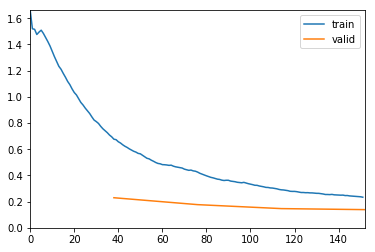

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.92E-05


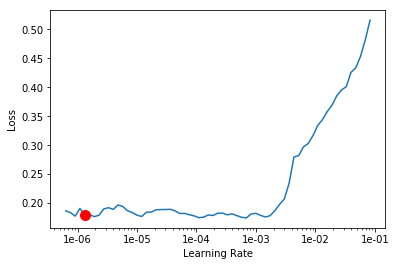

In [0]:
# init cnn rn34
learn_aug = cnn_learner(data_aug, models.resnet34, metrics=[accuracy,
                                                    error_rate,
                                                    Precision(average='macro'),
                                                    Recall(average='macro')], 
                    callback_fns=ShowGraph)

# fit the head (output layer)
learn_aug.fit_one_cycle(4) # .13
learn_aug.save('rn34-aug-stage-1')

# fit the pretrained early layers
learn_aug.unfreeze()
learn_aug.lr_find()#start_lr=1e-6)

learn_aug.recorder.plot(suggestion=True)  # .04685 4 epoch no_tfms

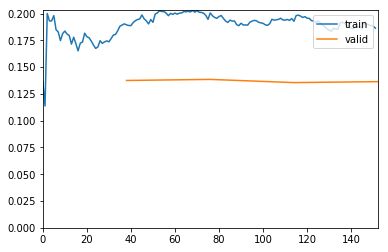

In [0]:
learn_aug.load('rn34-aug-stage-1')

# train on entire unfrozen network (early layers are pretrained)
learn_aug.fit_one_cycle(4, max_lr=slice(1e-064,1e-04))
learn_aug.save('rn34-aug-stage-2') # .035541 4 epochs

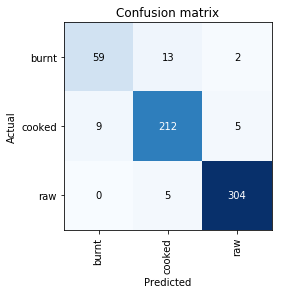

In [0]:
learn_aug.load('rn34-aug-stage-2')

interp34_aug = ClassificationInterpretation.from_learner(learn_aug)

interp34_aug.plot_confusion_matrix()

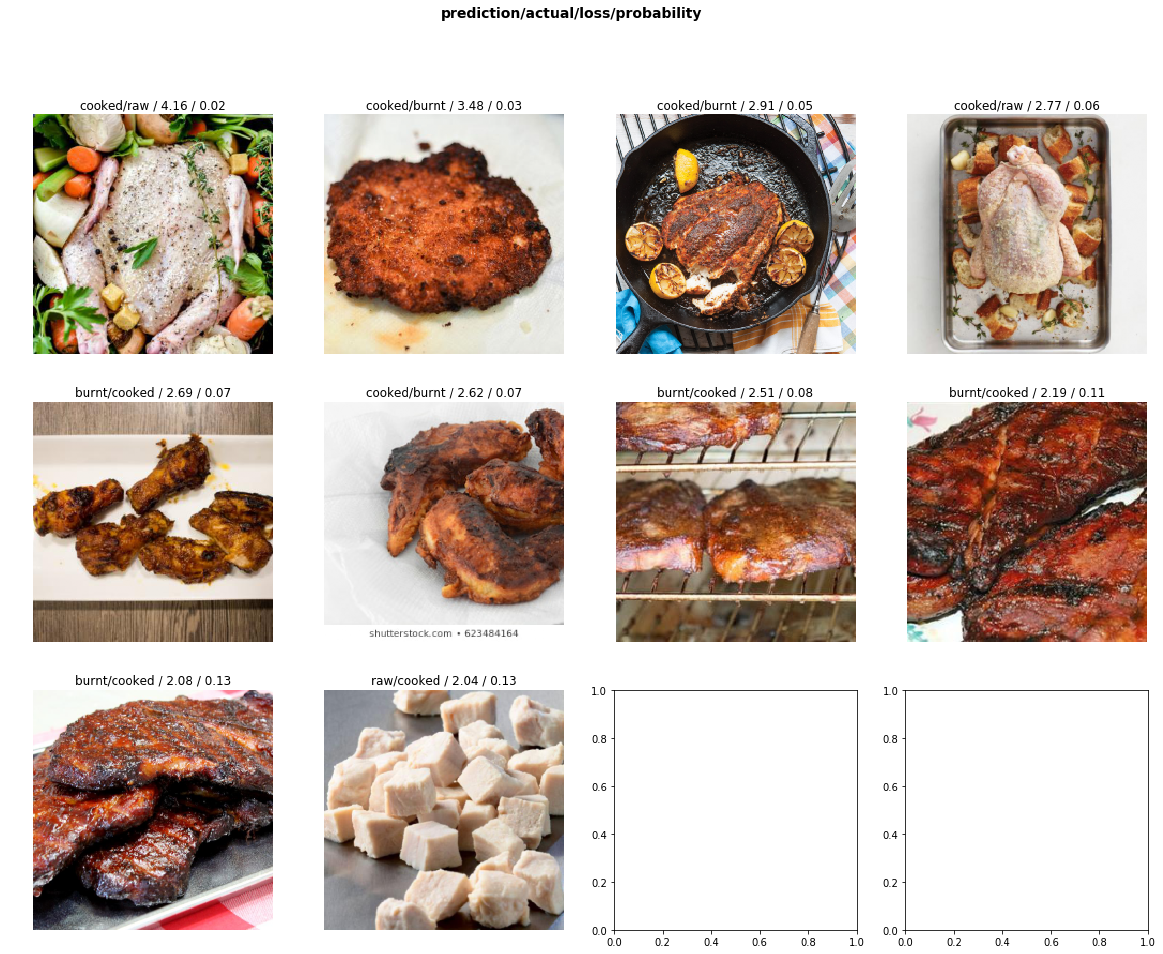

In [0]:
interp34_aug.plot_top_losses(10,figsize=(20,15))

### Discriminative layer training
When fitting a model you can pass a **list of learning rates (and/or weight decay amounts)**, which will apply a different rate to each layer group (i.e. the parameters of each module in self.layer_groups).

When working with a Learner on which you've called `split`, you can set hyperparameters in four ways:

1. `param = [val1, val2 ..., valn]` (n = number of layer groups)
2. `param = val`
3. `param = slice(start,end)`
4. `param = slice(end)`

If we chose to set it in way 1, we must specify a number of values exactly equal to the number of layer groups. 


If we chose to set it in way 2, the chosen value will be repeated for all layer groups. See Learner.lr_range for an explanation of the slice syntax).

### `lr_range`
`r_range[source][test]
lr_range(lr:Union[float, slice]) → ndarray`

Build differential learning rates from `lr`.

Rather than manually setting an LR for every group, it's often easier to use `Learner.lr_range`. This is a convenience method that returns one learning rate for each layer group. 

If you pass `slice(start,end)` then the first group's learning rate is start, the last is end, and the remaining are evenly geometrically spaced.

If you pass just `slice(end)` then the last group's learning rate is `end`, and all the other groups are `end/10`. For instance (for our learner that has 3 layer groups):

`learn.lr_range(slice(1e-5,1e-3)), learn.lr_range(slice(1e-3))
(array([1.e-05, 1.e-04, 1.e-03]), array([0.0001, 0.0001, 0.001 ]))`


### Grad-Cam

https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb



### Evaluate Predictions Class  

In [0]:
class Eval:
    def __init__(self,learner,img_data_bunch_val,class_list):
        
        self.learner = learner
        self.img_data_bunch_val = img_data_bunch_val # should pass data.valid_ds
        self.class_list = class_list # stores class labels
        self.predictions_df = None   # stores learner predict results 
    
        from collections import defaultdict
        self.class_preds = defaultdict(list) # to store probas for all classes
        
    def _predict_images(self):
        '''
        calls predict method to compute class prediction and probabilities 
        for each class for an image in DataImageBunch validation set and stores
        results in self.predictions_df
        
        returns    : None 
        '''
        pred_list = []
        actual_class_list = []
        class_list = []
        img_list = []
        # loop through all validation image files: 
        for i in range(len(self.img_data_bunch_val)):
            # get image from ImageDataBunch object
            img = self.img_data_bunch_val[i][0]
            # pred is tuple of 
            # class_pred, tensor(index), tensor([class predictions])
            pred = self.learner.predict(img)
            
            # store probas for all classes
            for ix,label in enumerate(self.class_list):
                self.class_preds[label] += [float(pred[2][ix])] # append [vals]
                
            actual_class = self.img_data_bunch_val[i][1]
            pred_class = pred[0]
            pred_ix = int(pred[1])
            pred_proba = float(pred[2][pred_ix])
            
            # store intermediate results
            pred_list.append(pred_proba)
            actual_class_list.append(actual_class)
            class_list.append(pred_class)
            img_list.append(img)
            
        results_dict = {'pred_proba':pred_list,
                        'pred_class':class_list,
                        'actual_class':actual_class_list,
                        'image':img_list}     

        self.predictions_df = pd.DataFrame(data=results_dict)
        
        # assign pred probas for each class
        for label in self.class_list:
            self.predictions_df['pred_'+label] = self.class_preds[label]
            
        
    def _show_preds(self,hard=True,k=10):
        '''
        display k top or bottom valdiation set predictions by prediction proba
        for rows in self.predicitons_df
        
        hard    : specify most difficult/easy prediction results to return, bool 
        k       : number of results to show, int
        returns : None
        '''
        if hard:
            df = self.predictions_df.sort_values('pred_proba').head(k) 
            df.reset_index(drop=True,inplace=True) 
        else:
            df = self.predictions_df.sort_values('pred_proba',ascending=False).head(k)
            df.reset_index(drop=True,inplace=True) 
            
        # display results
        for i in range(len(df)):
            result = df.iloc[i]
            print('\npredicted class: {}'.format(result['pred_class']))
            print('actual class: {}'.format(result['actual_class']))
            for label in self.class_list:
                print('predicted proba {}: {:.3f}'.format(label,result['pred_'+label]))
            display(result['image'])

            
# init Evaluation class
ev = Eval(learn,data.valid_ds,data.classes)

# compute and store predictions on validation set
ev._predict_images()


### Display Top 10 Most Difficult to Classify Images


predicted class: cooked
actual class: cooked
predicted proba burnt: 0.300
predicted proba cooked: 0.401
predicted proba raw: 0.299


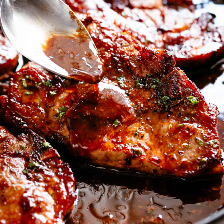


predicted class: cooked
actual class: raw
predicted proba burnt: 0.078
predicted proba cooked: 0.461
predicted proba raw: 0.461


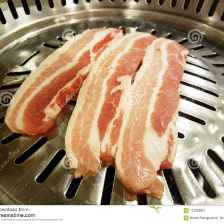


predicted class: cooked
actual class: burnt
predicted proba burnt: 0.497
predicted proba cooked: 0.501
predicted proba raw: 0.002


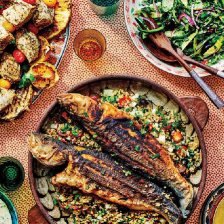


predicted class: cooked
actual class: raw
predicted proba burnt: 0.019
predicted proba cooked: 0.501
predicted proba raw: 0.480


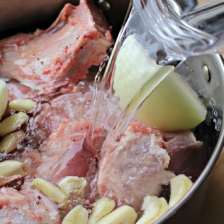


predicted class: cooked
actual class: cooked
predicted proba burnt: 0.003
predicted proba cooked: 0.506
predicted proba raw: 0.491


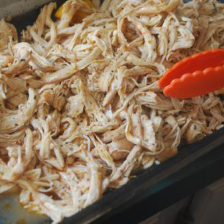


predicted class: burnt
actual class: burnt
predicted proba burnt: 0.509
predicted proba cooked: 0.485
predicted proba raw: 0.006


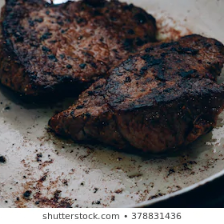


predicted class: cooked
actual class: raw
predicted proba burnt: 0.010
predicted proba cooked: 0.521
predicted proba raw: 0.469


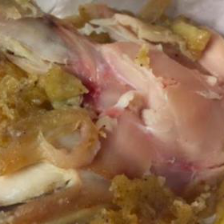


predicted class: burnt
actual class: burnt
predicted proba burnt: 0.525
predicted proba cooked: 0.474
predicted proba raw: 0.001


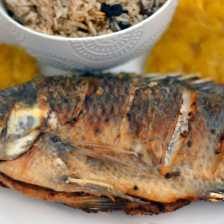


predicted class: raw
actual class: raw
predicted proba burnt: 0.068
predicted proba cooked: 0.402
predicted proba raw: 0.530


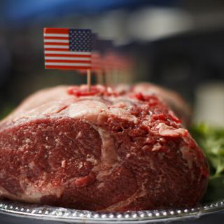


predicted class: cooked
actual class: cooked
predicted proba burnt: 0.456
predicted proba cooked: 0.536
predicted proba raw: 0.008


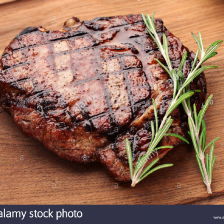

In [0]:
ev._show_preds(hard=True,k=10)

#### Display Top 10 Easiest to Classify Images


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


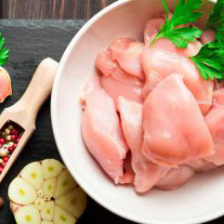


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


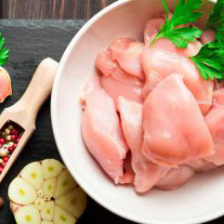


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


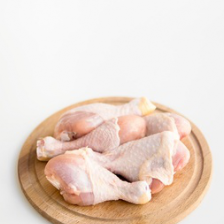


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


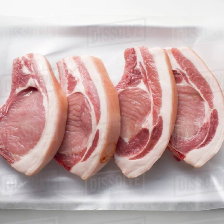


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


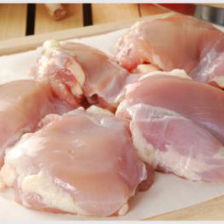


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


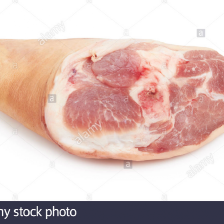


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


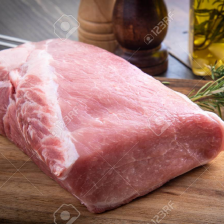


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


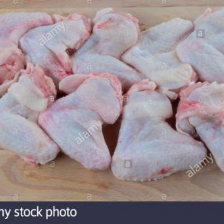


predicted class: raw
actual class: raw
predicted proba burnt: 0.000
predicted proba cooked: 0.000
predicted proba raw: 1.000


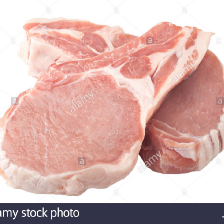


predicted class: cooked
actual class: cooked
predicted proba burnt: 0.000
predicted proba cooked: 1.000
predicted proba raw: 0.000


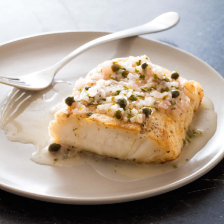

In [0]:
ev._show_preds(hard=False,k=10)